# Imports & Installations

In [1]:
!pip install pyforest
!pip install plotnine 
!pip install transformers
!pip install psycopg2-binary
!pip uninstall -y tensorflow-datasets
!pip install lit_nlp tfds-nightly transformers==4.1.1

In [2]:
# Automatic library importer (doesn't quite import everything yet)
from pyforest import *
# Expands Dataframe to view entire pandas dataframe
pd.options.display.max_colwidth = 750
# For tracking the duration of executed code cells
from time import time
# To connect to Blue Witness Labeler's DB
import psycopg2
# For visualizations
from plotnine import *
from plotnine.data import mpg
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# For BERT model
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences

<IPython.core.display.Javascript object>

# Reading in our Tweets



In [3]:
def get_df(db_url) -> pd.DataFrame:
    '''
    Connects to our Blue Witness Data Labeler and retrieves manually labelled text before converting them all into a pandas dataframe.
    
    Parameters
    ----------
    db_url: psycopg2 database
    
    Returns
    -------
    df: pandas datafarme 
        Contains thousands of text with appropriate police (non-)violence labels
    '''
    conn = psycopg2.connect(db_url)
    curs = conn.cursor()
    curs.execute("SELECT * FROM training;")
    cols = [k[0] for k in curs.description]
    rows = curs.fetchall()
    df = pd.DataFrame(rows, columns=cols)
    curs.close()
    conn.close()
    return df

<IPython.core.display.Javascript object>

In [4]:
# ALWAYS REMEMBER TO REMOVE THE PostgreSQL URL ASSIGNED TO THIS VARIABLE WHEN COMITTING TO OUR REPO
db_url = ""

In [5]:
data_labeler_df = get_df(db_url)
data_labeler_df

<IPython.core.display.Javascript object>

,id,tweets,labels
0,6,"A New Mexico State Police officer killed two people in crisis within five weeks, and demands for accountability are mounting https://t.co/mFYfC7kTFQ",5
1,7,I found some police badge stickers at work and I’ve started asking every officer I see if they want one with their name on it. I think it’s funny every time and so do they so I will continue this,0
2,8,"According to media reports, police said they arrested Sharma after a complaint from animal welfare organisation People for Animals. | via @philstarlife https://t.co/DO5ZZlNJHs",1
3,9,"The male who has the knife is now running northbound, per caller.",0
4,10,Changing the assignments of already existing cops and diverting already existing resources means you wouldn’t have increase the police budget.,0
...,...,...,...
6255,6262,"A carjacking suspect stopped at a roadblock dragged a state trooper through an intersection and crashed into four cars Tuesday, killing Hickerson, police said.",1
6256,6263,Adam Wheeler was wanted on three open felony warrants when he slammed his Donahoe Avenue apartment door in the face of a police officer investigating a drug complaint. The incident touched off a shootout with Cincinnati police that ended in Wheeler’s death.,5
6257,6264,The funny thing is they were goading @blackking136 when he revealed he’d contacted the police the other day. Now they’re deleting tweets and evidence quicker than a Trump staffer! 🤣🤣🤣🤣🤣🤣🤣🤣🤣,0
6258,6261,Police responded to the Sun Villa Motel for a report of a woman screaming. He rushed at them from the bathroom and was shot and killed.,0


In [6]:
def rank_wrangle():
  '''
  Loads in both synthetic tweets generated from GPT-2 and authentic tweets scraped and manually labelled from Twitter.
  Combines both sets of tweets together into a single dataframe.
  Drops any null values and duplicates.
  
  rank2_syn.txt, rank3_syn.txt, and rank4_syn.txt can be found in notebooks/labs37_notebooks/synthetic_tweets
  
  Parameters 
  ----------
  None

  Returns
  -------
  df: pandas dataframe
      Contains fully concatenated dataframe
  '''
  # Supplying our dataframes with proper labels
  column_headers = ['tweets', 'labels']
  # Reading in our three police force rank datasets
  synthetic_tweets_cop_shot = pd.read_csv("/content/cop_shot_syn.txt", sep = '/', names=column_headers)
  synthetic_tweets_run_over = pd.read_csv("/content/run_over_syn.txt", sep = '/', names=column_headers)
  synthetic_tweets_rank2 = pd.read_csv("/content/rank2_syn.txt", sep = '/', names=column_headers)
  synthetic_tweets_rank3 = pd.read_csv("/content/rank3_syn.txt", sep = '/', names=column_headers)
  synthetic_tweets_rank4 = pd.read_csv("/content/rank4_syn.txt", sep = '/', names=column_headers)
  # Concatenating all of our datasets into one
  compiled = pd.concat([data_labeler_df, synthetic_tweets_cop_shot, synthetic_tweets_run_over, synthetic_tweets_rank2, synthetic_tweets_rank3, synthetic_tweets_rank4])
  # Dropping unnecessary column
  compiled.drop('id', axis=1, inplace=True)
  # Discarding generated duplicates from GPT-2 while keeping the original Tweets
  compiled.drop_duplicates(subset='tweets', keep='first', inplace=True)
  # Dropping any possible NaNs
  if compiled.isnull().values.any():
      compiled.dropna(how='any', inplace=True)

  return compiled

In [7]:
# Applying our function above to view the contents of our dataframe
force_ranks = rank_wrangle()
force_ranks

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,tweets,labels
0,"A New Mexico State Police officer killed two people in crisis within five weeks, and demands for accountability are mounting https://t.co/mFYfC7kTFQ",5
1,I found some police badge stickers at work and I’ve started asking every officer I see if they want one with their name on it. I think it’s funny every time and so do they so I will continue this,0
2,"According to media reports, police said they arrested Sharma after a complaint from animal welfare organisation People for Animals. | via @philstarlife https://t.co/DO5ZZlNJHs",1
3,"The male who has the knife is now running northbound, per caller.",0
4,Changing the assignments of already existing cops and diverting already existing resources means you wouldn’t have increase the police budget.,0
...,...,...
917,"Following the death of an unarmed driver at the hands of police, protesters gathered outside the Miami Police Department. Footage shows a woman screaming and in sufficient pain that another protester is needed to carry her away quickly. Other protesters come to aid her and are summarily pepper-sprayed.",4
920,"At a protest outside the ICE facility in Portland, protesters built a barricade and threw objects at ICE agents and officers. Federal agents then deployed tear gas and stun grenades against the crowd.",4
921,"Following the death of an unarmed driver at the hands of police, protesters gathered outside the Brooklyn Center police precinct. Around 9pm, police fired tear gas and rubber bullets into the crowd.",4
922,"A journalist with Mill City Citizen Media is shot to death outside a Shake Shack restaurant after refusing to leave the building. The man was wearing a press jacket and held a sign above his head saying he was not allowed to be on the internet. Police said the man’s name was James Borden and he was receiving medical attention while hospitalized. He was shot once through the head and died shortly afterward. Mill City is about an hour away from Portland./4\r\nFollowing the death of an unarmed driver at the hands of police, protesters gathered outside the Brooklyn Center police precinct. Police there had been called to the precinct multiple times about a large fight and other protesters disruptive behavior. Police had deployed tear gas and...",4


# Visualizations

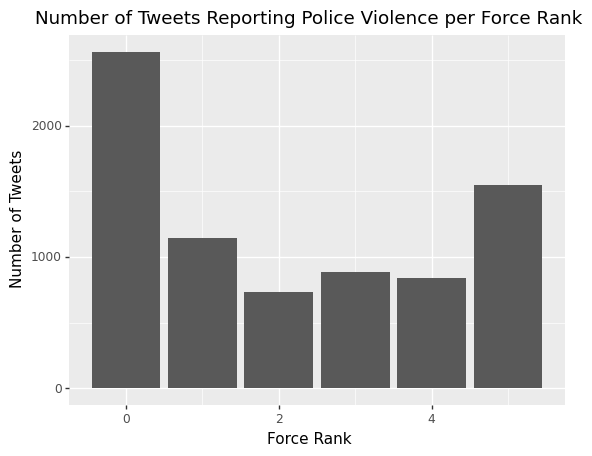

<ggplot: (8769373768393)>

In [8]:
%matplotlib inline

(ggplot(force_ranks)         # defining what dataframe to use
 + aes(x='labels')          # defining what variable/column to use
 + geom_bar(size=20)       # defining the type of plot to use and its size
 + labs(title='Number of Tweets Reporting Police Violence per Force Rank', x='Force Rank', y='Number of Tweets')
)

In [9]:
# Creating custom donut chart with Plotly
labels = ['0 - No Police Presence', '5 - Lethal Force (Guns & Explosives)', '1 - Non-violent Police Presence', '3 - Blunt Force Trauma (Batons & Shields)', '4 - Chemical & Electric Weapons (Tasers & Pepper Spray)', '2 - Open Handed (Arm Holds & Pushing)']
values = force_ranks.labels.value_counts()

bw_colors = ['rgb(138, 138, 144)', 'rgb(34, 53, 101)', 'rgb(37, 212, 247)', 'rgb(59, 88, 181)', 'rgb(56, 75, 126)',
                'rgb(99, 133, 242)']

# Using 'pull' on Rank 5 to accentuate the frequency of the most excessive use of force by police
# 'hole' determines the size of the donut chart
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values, pull=[0, 0.2, 0, 0, 0, 0],
                             hole=.3,
                             name='Blue Witness',
                             marker_colors=bw_colors)])

# Displaying our donut chart
fig.update(layout_title_text='Percentage of Tweets Reporting Police Violence per Force Rank')
fig = go.Figure(fig)
fig.show()

# Preparing Data for BERT

Splitting dataframe into training and testing sets before converting to parquet for later reference/resource.

In [10]:
def parquet_and_split():
  '''
  Splits our data into a format amicable to NLP modeling.
  Saves our original dataframe as well as the two split dataframes into parquet files for later reference/use.
  
  -----
  Parameters 
  ------
  None
  Returns
  -------
  df: pandas dataframes
    Contains two split dataframes ready to be fit to and tested against a model
  '''
  # Splitting dataframe into training and testing sets for modeling
  # 20% of our data will be reserved for testing
  training, testing = train_test_split(force_ranks, test_size=0.2)
  # Sanity Check
  if force_ranks.shape[0] == training.shape[0] + testing.shape[0]:
      print("Sanity Check - Succesful!")
  else:
      print("Sanity Check - Unsuccessful!")
  # Converting dataframes to parquet format for later reference
  # Using parquet as our new dataset storage format as they cannot be edited like CSVs can. They are immutable.
  # For viewing in vscode, install the parquet-viewer extension: https://marketplace.visualstudio.com/items?itemName=dvirtz.parquet-viewer
  training.to_parquet('synthetic_training.parquet')
  testing.to_parquet('synthetic_testing.parquet')
  force_ranks.to_parquet('synthetic_complete.parquet')

  return training, testing

In [11]:
training, testing = parquet_and_split()

<IPython.core.display.Javascript object>

Sanity Check - Succesful!


# BERT

## Training our NLP Multi-Class Classification Model

In [12]:
def bert_trainer(df, output_dir: str, epochs: int):
    start = time()
    max_len = 280
    if torch.cuda.is_available():
        print("CUDA Active")
        device = torch.device("cuda")
    else:
        print("CPU Active")
        device = torch.device("cpu")
    sentences = df["tweets"].values
    labels = df["labels"].values
    tokenizer = BertTokenizer.from_pretrained(
        'bert-base-uncased',
        do_lower_case=True,
    )
    inputs = [
        tokenizer.encode(sent, add_special_tokens=True) for sent in sentences
    ]
    inputs_ids = pad_sequences(
        inputs,
        maxlen=max_len,
        dtype="long",
        value=0,
        truncating="post",
        padding="post",
    )
    attention_masks = [
        [int(token_id != 0) for token_id in sent] for sent in inputs_ids
    ]
    train_inputs = torch.tensor(inputs_ids)
    train_labels = torch.tensor(labels)
    train_masks = torch.tensor(attention_masks)
    batch_size = 32
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(
        train_data,
        sampler=train_sampler,
        batch_size=batch_size,
    )
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=6,
        output_attentions=False,
        output_hidden_states=False,
    )
    if torch.cuda.is_available():
        model.cuda()
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps,
    )
    loss_values = []
    print('\nTraining...')
    for epoch_i in range(1, epochs + 1):
        print(f"\nEpoch: {epoch_i}")
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)
        print(f"Average Loss: {avg_train_loss}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"\nSaving model to {output_dir}")
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    end = time()
    total_run_time_in_hours = (((end - start)/60)/60)
    rounded_total_run_time_in_hours = np.round(total_run_time_in_hours, decimals=2)
    print(f"Finished training in {rounded_total_run_time_in_hours} hours!")

In [13]:
!nvidia-smi
# If running on Colab, the best GPU to have in use is the NVIDIA Tesla P100

Mon Sep 20 21:42:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Colab notebook may crash the first time this code cell is run. 
# Running this cell again after runtime restart shouldn't produce any more issues.
bert_trainer(training, 'saved_model', epochs=50)

CUDA Active


Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializ


Training...

Epoch: 1
Average Loss: 0.9867600659632312

Epoch: 2
Average Loss: 0.5368224644135935

Epoch: 3
Average Loss: 0.36541898069912904

Epoch: 4
Average Loss: 0.23342622747075373

Epoch: 5
Average Loss: 0.14578060786495556

Epoch: 6
Average Loss: 0.10112217858607442

Epoch: 7
Average Loss: 0.06938433699029947

Epoch: 8
Average Loss: 0.04572113623741261

Epoch: 9
Average Loss: 0.03439011470501557

Epoch: 10
Average Loss: 0.025774610291869702

Epoch: 11
Average Loss: 0.016303938032077248

Epoch: 12
Average Loss: 0.018726346491645403

Epoch: 13
Average Loss: 0.010810602327852168

Epoch: 14
Average Loss: 0.008389738373129044

Epoch: 15
Average Loss: 0.003082605297019744

Epoch: 16
Average Loss: 0.005666346531171337

Epoch: 17
Average Loss: 0.008038394296978519

Epoch: 18
Average Loss: 0.004799127399286863

Epoch: 19
Average Loss: 0.007756974010736141

Epoch: 20
Average Loss: 0.0072256915181256355

Epoch: 21
Average Loss: 0.0033441312797186616

Epoch: 22
Average Loss: 0.000921090002

<IPython.core.display.Javascript object>


Saving model to saved_model


<IPython.core.display.Javascript object>

Finished training in 4.39 hours!


## Making Predictions

In [16]:
class FrankenBert:
    """
    Implements BertForSequenceClassification and BertTokenizer
    for binary classification from a saved model
    """

    def __init__(self, path: str):
        """
        If there's a GPU available, tell PyTorch to use the GPU.
        Loads model and tokenizer from saved model directory (path)
        """
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.model.to(self.device)

    def predict(self, text: str):
        """
        Makes a binary classification prediction based on saved model
        """
        inputs = self.tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=280,
            return_tensors='pt',
        ).to(self.device)
        output = self.model(**inputs)
        prediction = output[0].softmax(1)
        tensors = prediction.detach().cpu().numpy()
        result = np.argmax(tensors)
        confidence = tensors[0][result]
        return f"Rank: {result}, {100 * confidence:.2f}%"

In [17]:
model = FrankenBert('saved_model')

In [18]:
model.predict("Mickey Mouse is in the house")

<IPython.core.display.Javascript object>

'Rank: 0, 100.00%'

In [19]:
model.predict("Cops gave me a speeding ticket for walking too fast")

<IPython.core.display.Javascript object>

'Rank: 1, 100.00%'

In [20]:
model.predict("Officer Kelly was shot and killed")

<IPython.core.display.Javascript object>

'Rank: 1, 100.00%'

In [21]:
model.predict("A Texas Department of Public Safety (DPS) trooper ran over and killed a man who was in the road near the State Capitol early Thursday morning, according to the Austin Police Department (APD). The crash happened at around 3:45 a.m. Thursday just west of the Texas State Capitol building. The trooper was heading northbound on Colorado Street and as he was turning left on 13th Street, the trooper hit the pedestrian. DPS said the crash happened while the trooper was patrolling the area.")

<IPython.core.display.Javascript object>

'Rank: 5, 100.00%'

In [22]:
model.predict("Cop ran me over with his SUV")

<IPython.core.display.Javascript object>

'Rank: 5, 100.00%'

In [23]:
model.predict("Cops hit her with a baton")

<IPython.core.display.Javascript object>

'Rank: 3, 100.00%'

In [24]:
model.predict("Cops sprayed my mom with pepper spray")

<IPython.core.display.Javascript object>

'Rank: 4, 100.00%'

In [25]:
model.predict("Cops shot rubber bullets at the crowd")

<IPython.core.display.Javascript object>

'Rank: 4, 99.98%'

In [26]:
model.predict("Police used tear gas on a pedestrian for no reason")

<IPython.core.display.Javascript object>

'Rank: 4, 100.00%'

In [27]:
model.predict("Cops killed that woman")

<IPython.core.display.Javascript object>

'Rank: 5, 99.99%'

In [28]:
model.predict("Yesterday I saw a policeman hit a poor person behind my house. I wonder whats going on")

<IPython.core.display.Javascript object>

'Rank: 2, 99.99%'

In [29]:
model.predict("Man ran up to me and pepper sprayed me. I've called the cops, but they have not gotten themselves involved yet.")

<IPython.core.display.Javascript object>

'Rank: 4, 100.00%'

## Saving Trained Model 

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [33]:
#path that contains folder you want to copy
%cd /content/gdrive/MyDrive/ColabNotebooks/Labs/saved_model

# copy local folder to folder on Google Drive 
%cp -av /content/saved_model saved_model

/content/gdrive/MyDrive/ColabNotebooks/Labs/saved_model
'/content/saved_model' -> 'saved_model'
'/content/saved_model/.ipynb_checkpoints' -> 'saved_model/.ipynb_checkpoints'
'/content/saved_model/config.json' -> 'saved_model/config.json'
'/content/saved_model/pytorch_model.bin' -> 'saved_model/pytorch_model.bin'
'/content/saved_model/tokenizer_config.json' -> 'saved_model/tokenizer_config.json'
'/content/saved_model/special_tokens_map.json' -> 'saved_model/special_tokens_map.json'
'/content/saved_model/vocab.txt' -> 'saved_model/vocab.txt'
